# Matflow Crystal Plasticity Modelling diffraction post-processing examples

This notebook is intended as a walkthrough for use of digital x-ray analysis of simualted volume elements from crystal plastcity models.
Follow the steps described to produce detailed analysis of crystal plasticity model results for comparison/validation against experimental X-ray diffraction analysis, or for a better description of your model predictions.

In [1]:
# Firstly, load in the required python libraries and functions:
# libraries and functions from the web:
import numpy as np
from matflow import load_workflow
import pickle
from cycler import cycler
import matplotlib.pyplot as plt
from defdap.quat import Quat

# libraries and functions local to this repository:
import utils
from utils import import_diff_params
from lattice_strain import VE_phase_mask
from lattice_strain import lattice_strain
from plotting import plot_latticestrain
from plotting import plot_truestrain_peakint
from plotting import plot_lattice_strain_dist_inc
from texture import write_quat_txts


Specify the workflow and therefore simulation results you would like to post-process by changing the path string of the `workflow_dir` variable in the cell below. This should point to the directory containing the `workflow.hdf5` file where the matflow simulation results have been saved following a successfully run matflow-damask workflow.

The runtime of this cell depends on the size of the `workflow.hdf5` file contained within your workflow directory.
**20Gbs can take up to 2mins to load**.

In [2]:

# define path to completed matflow workflow directory containing result.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_elongated_TensionY64x_1mms-1_Xprism_alt0-plastic_CRSS_14_210_28_0_0_224_224_2023-12-19-123309/"

# use load_workflow to import the result.hdf5 file into jupyter as a variable...
workflow = load_workflow(workflow_dir)
sim_ve_load = workflow.tasks.simulate_volume_element_loading.elements[0]
ve = sim_ve_load.inputs.volume_element
ve_response = sim_ve_load.outputs.volume_element_response


Loading matflow config from /mnt/iusers01/jf01/y15576gb/.matflow/config.yml
Loading task schemas from 1 file(s)...OK!
Loading software definitions from 1 file(s)...OK!


---
## Plotting Stress-strain of a matflow-DAMASK simulation.
The following code takes a matflow workflow's `workflow.hdf5` file and plots stress against strain.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }

      volume_data: # For global stress-strain
        - field_name: sigma
          out_name: sigma
        - field_name: epsilon_V^0(F)
          out_name: epsilon_V^0(F)

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

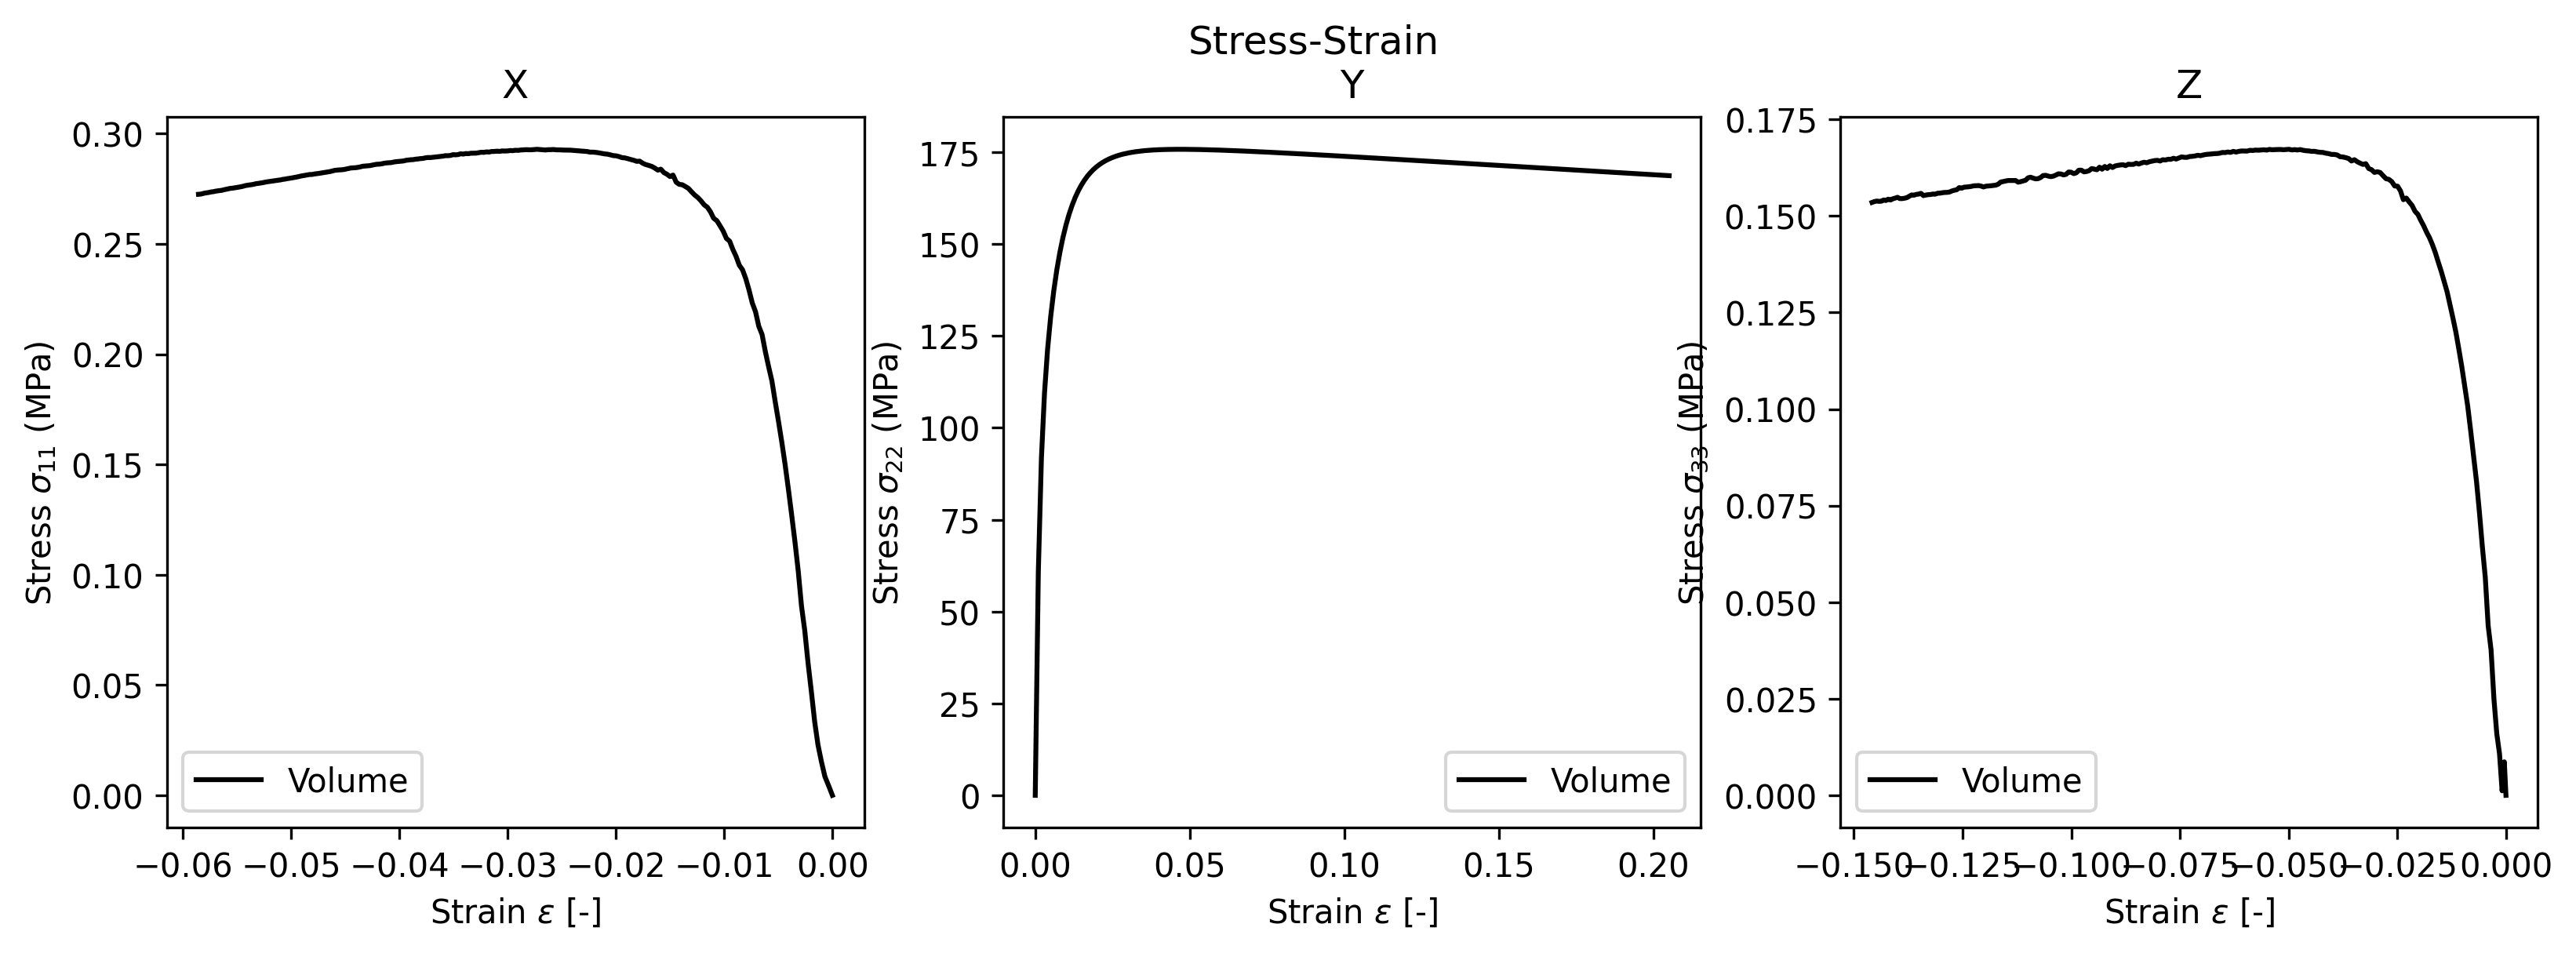

In [3]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

phases_ss = {}
stress_strain = {}

for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
#     for phase in sim_ve_load.inputs.phases.keys():
#         phases_ss = {f'{phase}_stress' : ve_response["phase_data"][f"{phase}_sigma"]["data"][:, :, i, i].mean(axis=1)/1e6, # MPa
#                      f'{phase}_strain' : ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][:, :, i, i].mean(axis=1)
#                     }
#         if phase == "Ti_alpha":
#             axs[i].plot(phases_ss[f'{phase}_strain'], abs(phases_ss[f'{phase}_stress']),
#                         marker='h', markersize=8, color="tab:blue",
#                         label = phase)
#         elif phase == "Ti_beta":
#             axs[i].plot(phases_ss[f'{phase}_strain'], abs(phases_ss[f'{phase}_stress']),
#                         marker='s', markersize=8, color="tab:orange",
#                         label = phase)
        
    stress_strain[axis] = {
                           # mean over mat points already
#                            'stress' : ve_response["volume_data"]["sigma"]["data"][:,i,i]/1e6, # MPa
#                            'strain' : ve_response["volume_data"]["epsilon_V^0(F)_vM"]["data"],
                           # new way (using full tensors)
                           'stress' : ve_response["volume_data"]["sigma"]["data"][:, :, i, i].mean(axis=1)/1e6, # MPa
                           'strain' : ve_response["volume_data"]["epsilon_V^0(F)"]["data"][:, :, i, i].mean(axis=1)
                          }
    axs[i].plot(stress_strain[axis]['strain'], abs(stress_strain[axis]['stress']),
                linestyle="solid", marker='None', color="k",
                label = "Volume")
        
    axs[i].title.set_text(f"{axis}")
    axs[i].set_facecolor("white")
    axs[i].set_xlabel(f"Strain $\epsilon$ [-]")
    axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)")
    axs[i].legend()
    
# save stress_strain dict as .pkl file to avoid reloading workflow.hdf5 file:
pickle.dump(stress_strain, open(workflow_dir+'stress_strain.pkl', 'wb'))
# save figure as .png:
plt.savefig(f'{workflow_dir}stress_strain.png')

---
## Extract orientation data and write to .txt files for MTEX to generate ODFs and plot pole figures
Use of MTEX for representation of texture evolution is recommended. As there is not yet code for the extraction of quaternion data using matlab, here python is used to write the data to txt files which can be read into matlab and turned into pole figures and ODF sections.

In [7]:

# saves .txt files containing quats to workflow_name/sim_VE_loading_task/phasename/
for phase in ["Ti_alpha"]: # list phases as stings here
    write_quat_txts(workflow_dir, phase) # function extracts orientation data from 'phase_data'
    

Extracting quaternions from task_2_simulate_volume_element_loading...


ValueError: Provided argument 'file_obj' does not appear to be a valid hickle file! (Unable to allocate 3.53 GiB for an array with shape (201, 64, 64, 64, 3, 3) and data type float64)

---
## Calculate lattice strain and plane 'intensities' from a matflow-DAMASK workflow
The following code takes a matflow workflow's `workflow.hdf5` file and plots true stress against lattice strain for each crystallographic plane.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM
            
      field_data: # for lattice strain
        - field_name: phase
        - field_name: epsilon_V^2(F_e) # left elastic strain tensor
#        - field_name: epsilon_U^2(F_e) # right elastic strain tensor (dont need)
        - field_name: F_p # plastic deformation gradient tensor
        - field_name: O # orientations as quaternions

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p, O]
```

Step-by-step:
1. Import crystallographic parameters from crystallographic_params.yaml file.
2. Get unit vector describing the measurement direction given axis as string with function eg. "X" into "[1, 0, 0]"
3. Check for diffraction using tolerance of $5^o$ of satisfying Bragg condition.
4. Read lattice strains for these material points and add to bin for lattice plane label.
5. Plot lattice strains of each plane against true stress of the volume element.

Warning: This can take between up to 2hrs to compute for a $128^3$ volume element with $100$ loading steps.
**This is only required once.** Calculated data is saved to the workflow directory defined so that plot features can be changed quickly.

In [4]:
# Enter only the phases which are present in the workflow
yaml_dict, phases = import_diff_params("Ti_alpha","Ti_beta")

In [5]:
# get number of increments...
oris = ve_response['field_data']['O']['data']
ori_incs = ve_response['field_data']['O']['meta']['increments']

In [6]:

latticestrain={}
plane_intensity={}
# for axis in ["X", "Y", "Z"]: # plots for every axis direction
for axis in ["X","Y","Z"]:
    tensor_comp, unit_vector = utils.tensorcomps_fromaxis(axis)
    latticestrain[axis]={}
    plane_intensity[axis]={}

    for phase_name, phase in phases.items():
        print(f"Scanning phase {phase_name} for planes aligned in {axis}...")

        phase_idx, phase_mask = VE_phase_mask(phase_name, ve_response)
        # Using left Cauchy-Green defomation tensor for elastic strain...
        Ee = ve_response['field_data']['epsilon_V^2(F_e)']['data'][:, phase_mask, :, :]
        Ee_incs = ve_response['field_data']['epsilon_V^2(F_e)']['meta']['increments']

        # calculate lattice strains and count material points with that lattice strain
        latticestrain[axis][phase_name], plane_intensity[axis][phase_name] = lattice_strain(phase, phase_name, oris, ori_incs, phase_idx, phase_mask, Ee, Ee_incs, axis)

# save data to .pkl files to avoid having to recalculate to change the graphs.
with open(workflow_dir+'lattice_strain.pkl', 'wb') as ls:
    pickle.dump(latticestrain, ls)
with open(workflow_dir+'plane_intensity.pkl', 'wb') as pi:
    pickle.dump(plane_intensity, pi)

Scanning phase Ti_alpha for planes aligned in X...
Processing plane {10-10}...
Processing plane {0002}...
Processing plane {10-11}...
Processing plane {11-20}...
Scanning phase Ti_beta for planes aligned in X...
Processing plane {110}...
Processing plane {200}...
Processing plane {220}...
Scanning phase Ti_alpha for planes aligned in Y...
Processing plane {10-10}...
Processing plane {0002}...
Processing plane {10-11}...
Processing plane {11-20}...
Scanning phase Ti_beta for planes aligned in Y...
Processing plane {110}...
Processing plane {200}...
Processing plane {220}...
Scanning phase Ti_alpha for planes aligned in Z...
Processing plane {10-10}...
Processing plane {0002}...
Processing plane {10-11}...
Processing plane {11-20}...
Scanning phase Ti_beta for planes aligned in Z...
Processing plane {110}...
Processing plane {200}...
Processing plane {220}...


---
## plot true stress against lattice strain

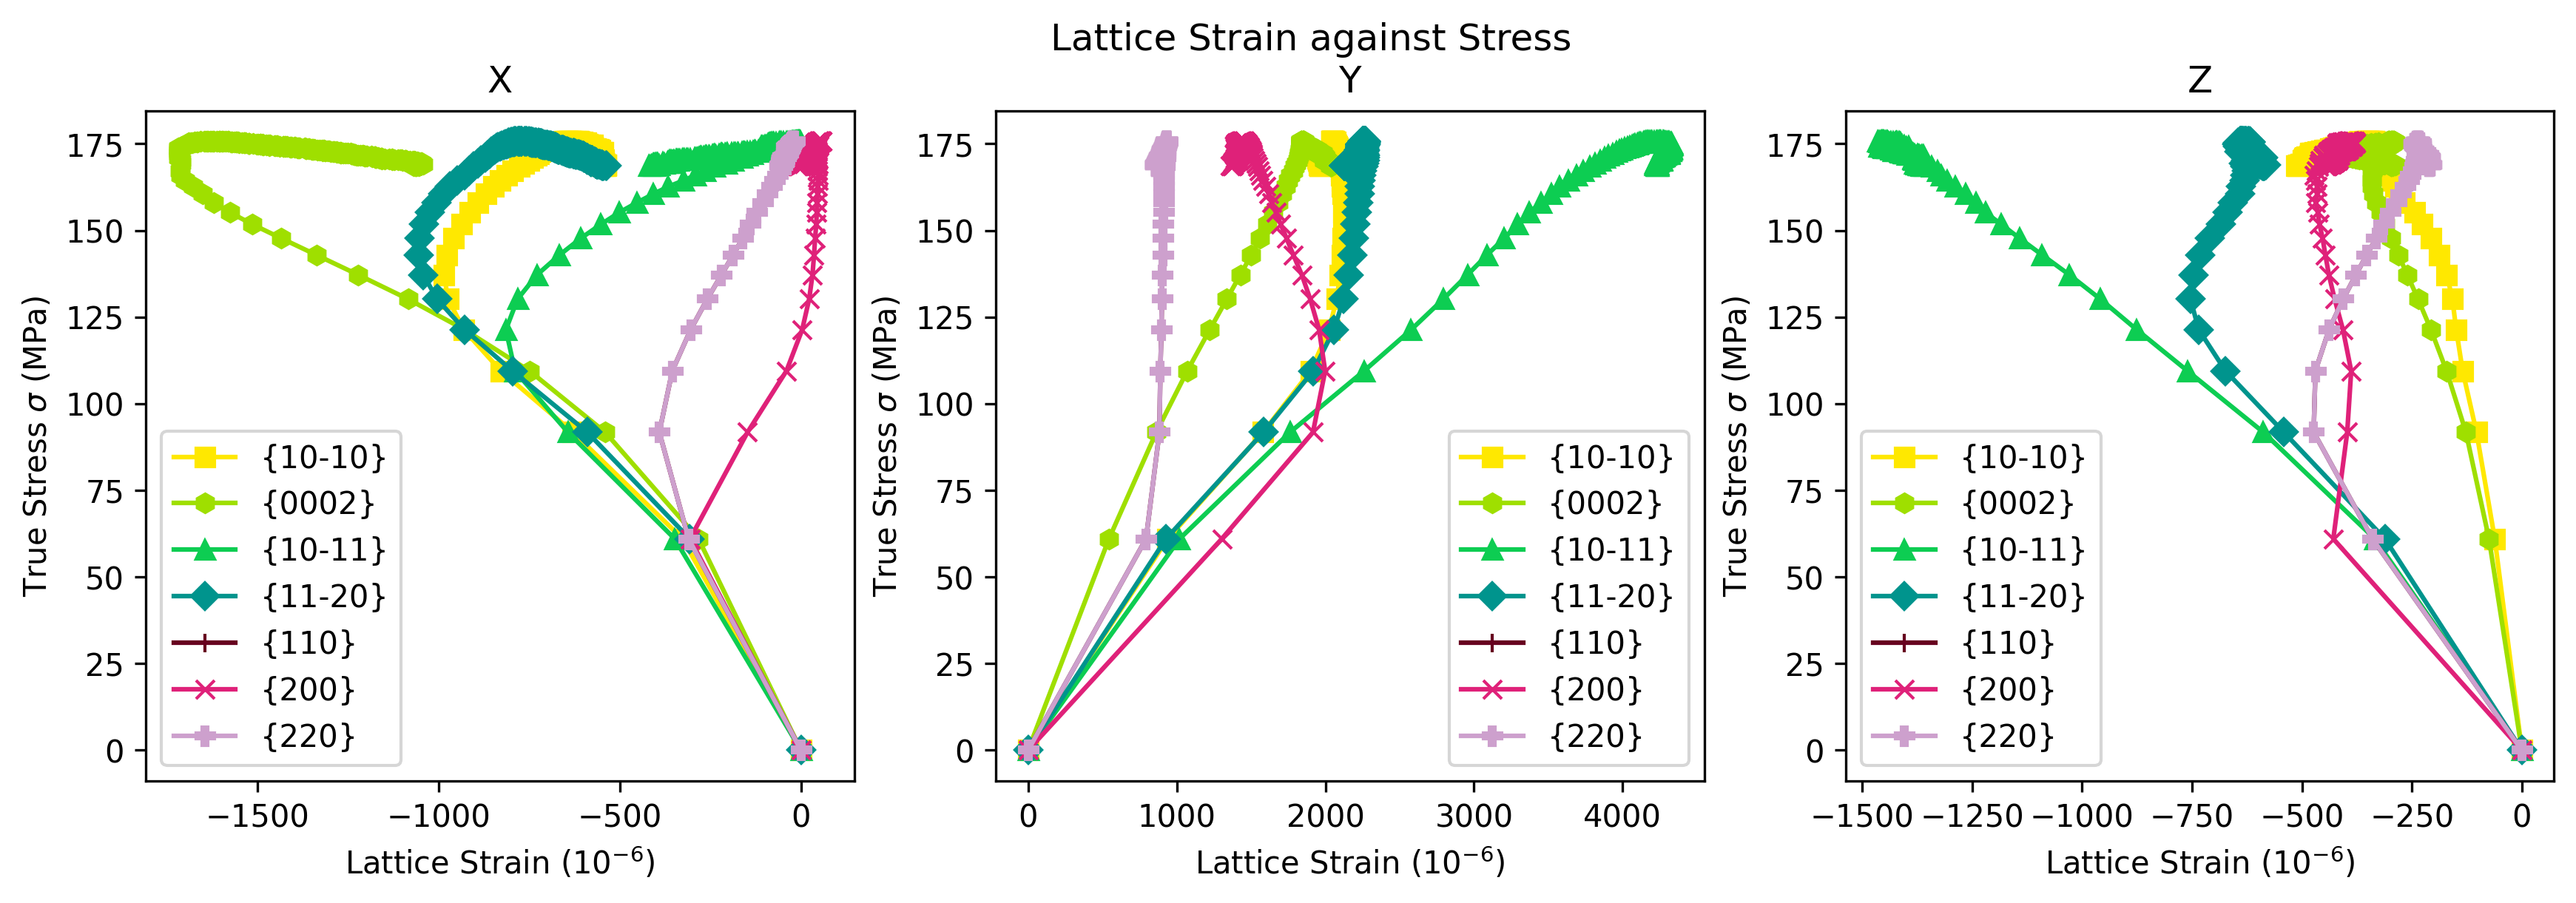

In [7]:
%matplotlib inline

# output with mean over material points per inc
# true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]
# full tensor output
true_stress = ve_response['volume_data']['sigma']['data'][:,:,1, 1].mean(axis=1)/1e6 # this is for Y axis. X would be [0, 0]
latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300, facecolor='w') # one row, three coloumns
fig.suptitle('Lattice Strain against Stress')
# for i, axis in enumerate(["X", "Y", "Z"]):
for i, axis in enumerate(["X","Y","Z"]): # for only one axis:
    plot_latticestrain(axs[i], abs(true_stress), latticestrain, axis, incs="*", xlim=None, ylim=None)

plt.savefig(f'{workflow_dir}latticestrain.png')

## plot plane intensity against true strain

Could get some more info here - such as the total material points over all the planes counted here, as this should not equal the actual amount of material points in the model defined by the grid size.

With this could calculate volume fraction of grains with a specific orientation. Either as a fraction of all material points or a fraction of the material points with some plane aligned along specific axis direction.

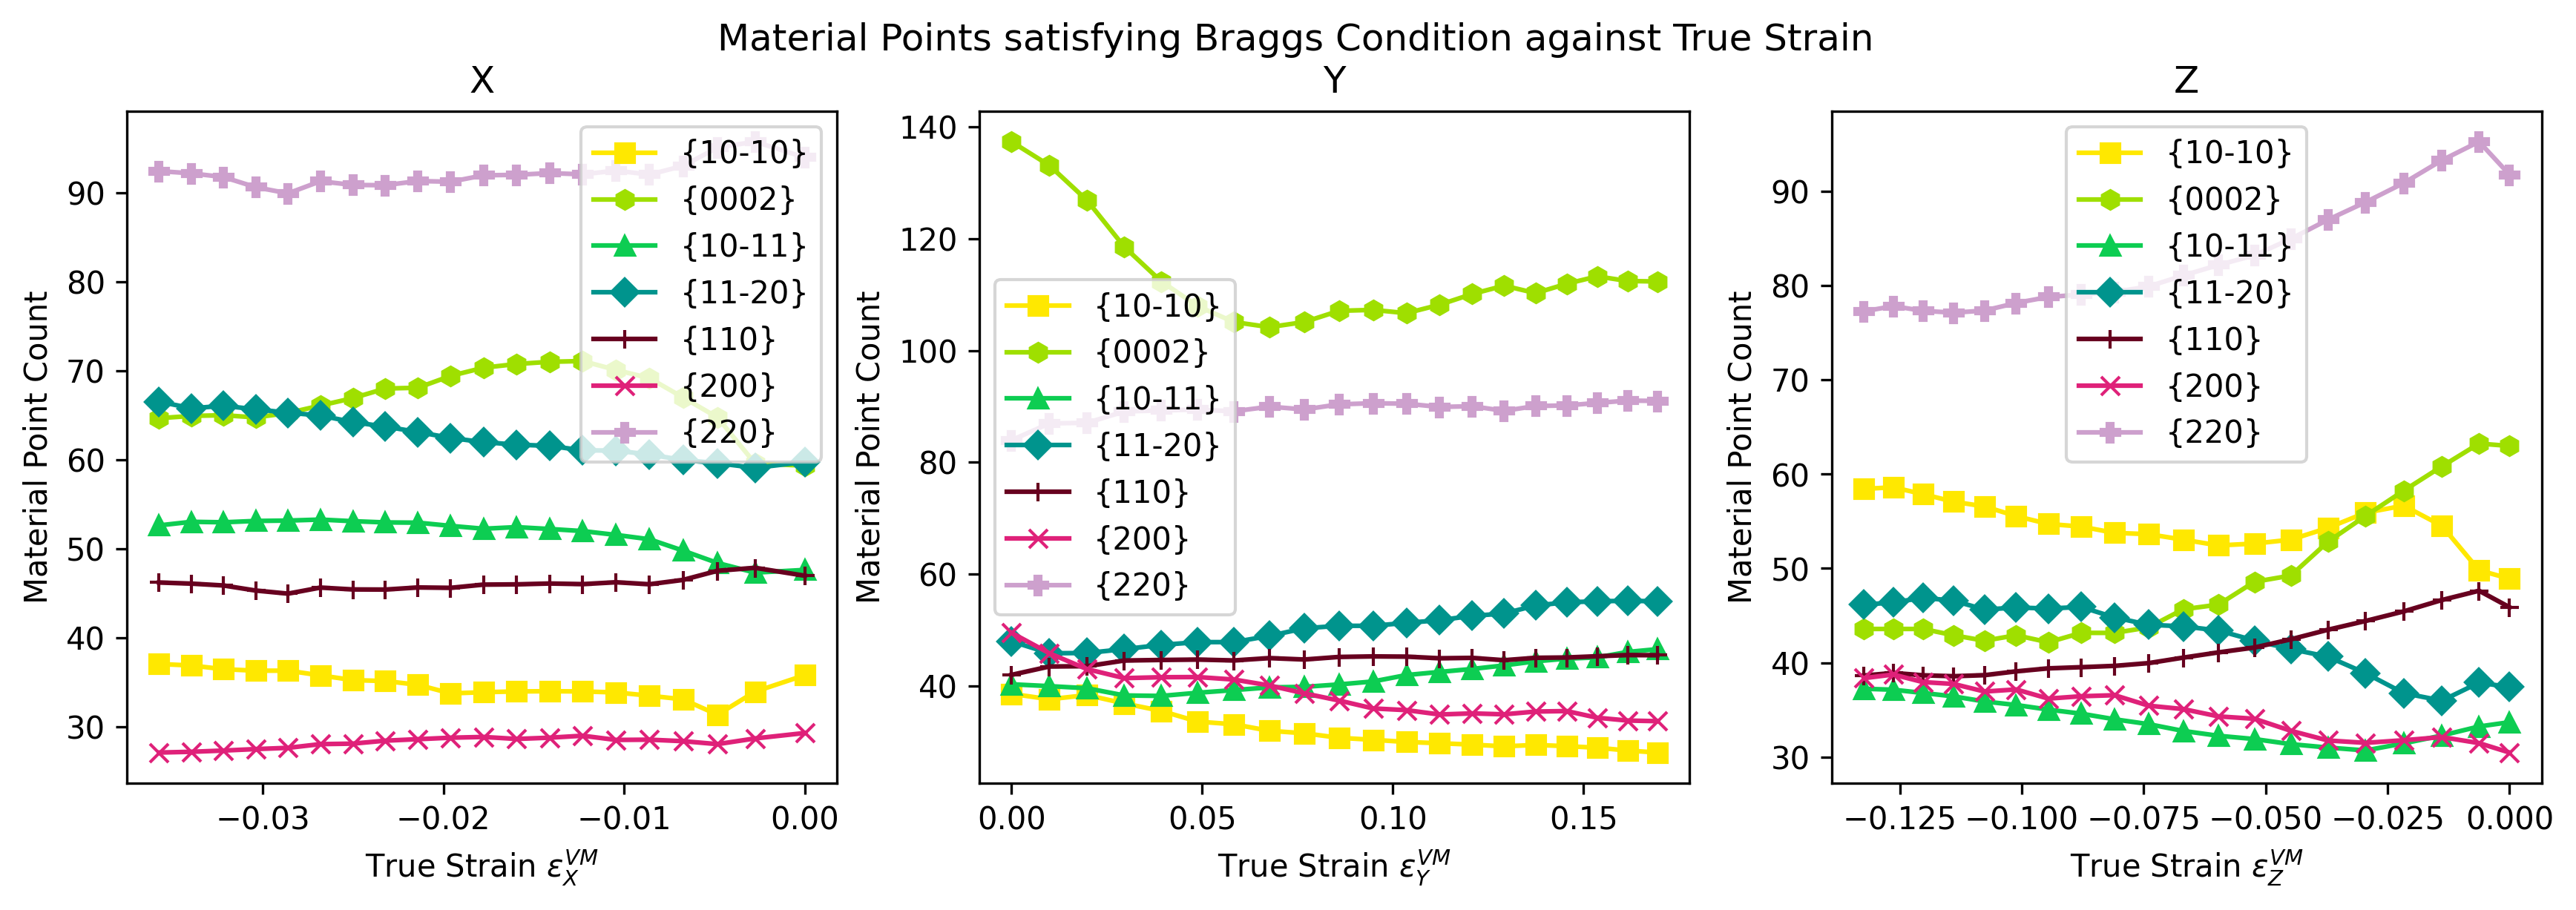

In [8]:
%matplotlib inline

plane_intensity = pickle.load(open(workflow_dir+'plane_intensity.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300, facecolor='w') # one row, three coloumns
fig.suptitle(f"Material Points satisfying Braggs Condition against True Strain")
for i, axis in enumerate(["X", "Y", "Z"]):
    true_strain = ve_response['volume_data']['epsilon_V^0(F)']['data'][:,:,i,i].mean(axis=1)
    plot_truestrain_peakint(axs[i], plane_intensity, true_strain, axis, phases.keys(), xlim=None, ylim=None)

plt.savefig(f'{workflow_dir}matpoint_count.png')

## plot distrubution of lattice strain

In [9]:
hist_shapes = np.zeros(3)
hist_shapes[0] = latticestrain['X']['Ti_alpha']['{0002}'][-1].shape[0]
hist_shapes[1] = latticestrain['X']['Ti_alpha']['{10-10}'][-1].shape[0]
hist_shapes[2] = latticestrain['X']['Ti_alpha']['{11-20}'][-1].shape[0]
args = np.argsort(-hist_shapes)
print(args)

[ 708. 1551. 2235.]
[2 1 0]


phase: Ti_alpha Direction: X
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 
phase: Ti_alpha Direction: Y
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 
phase: Ti_alpha Direction: Z
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 


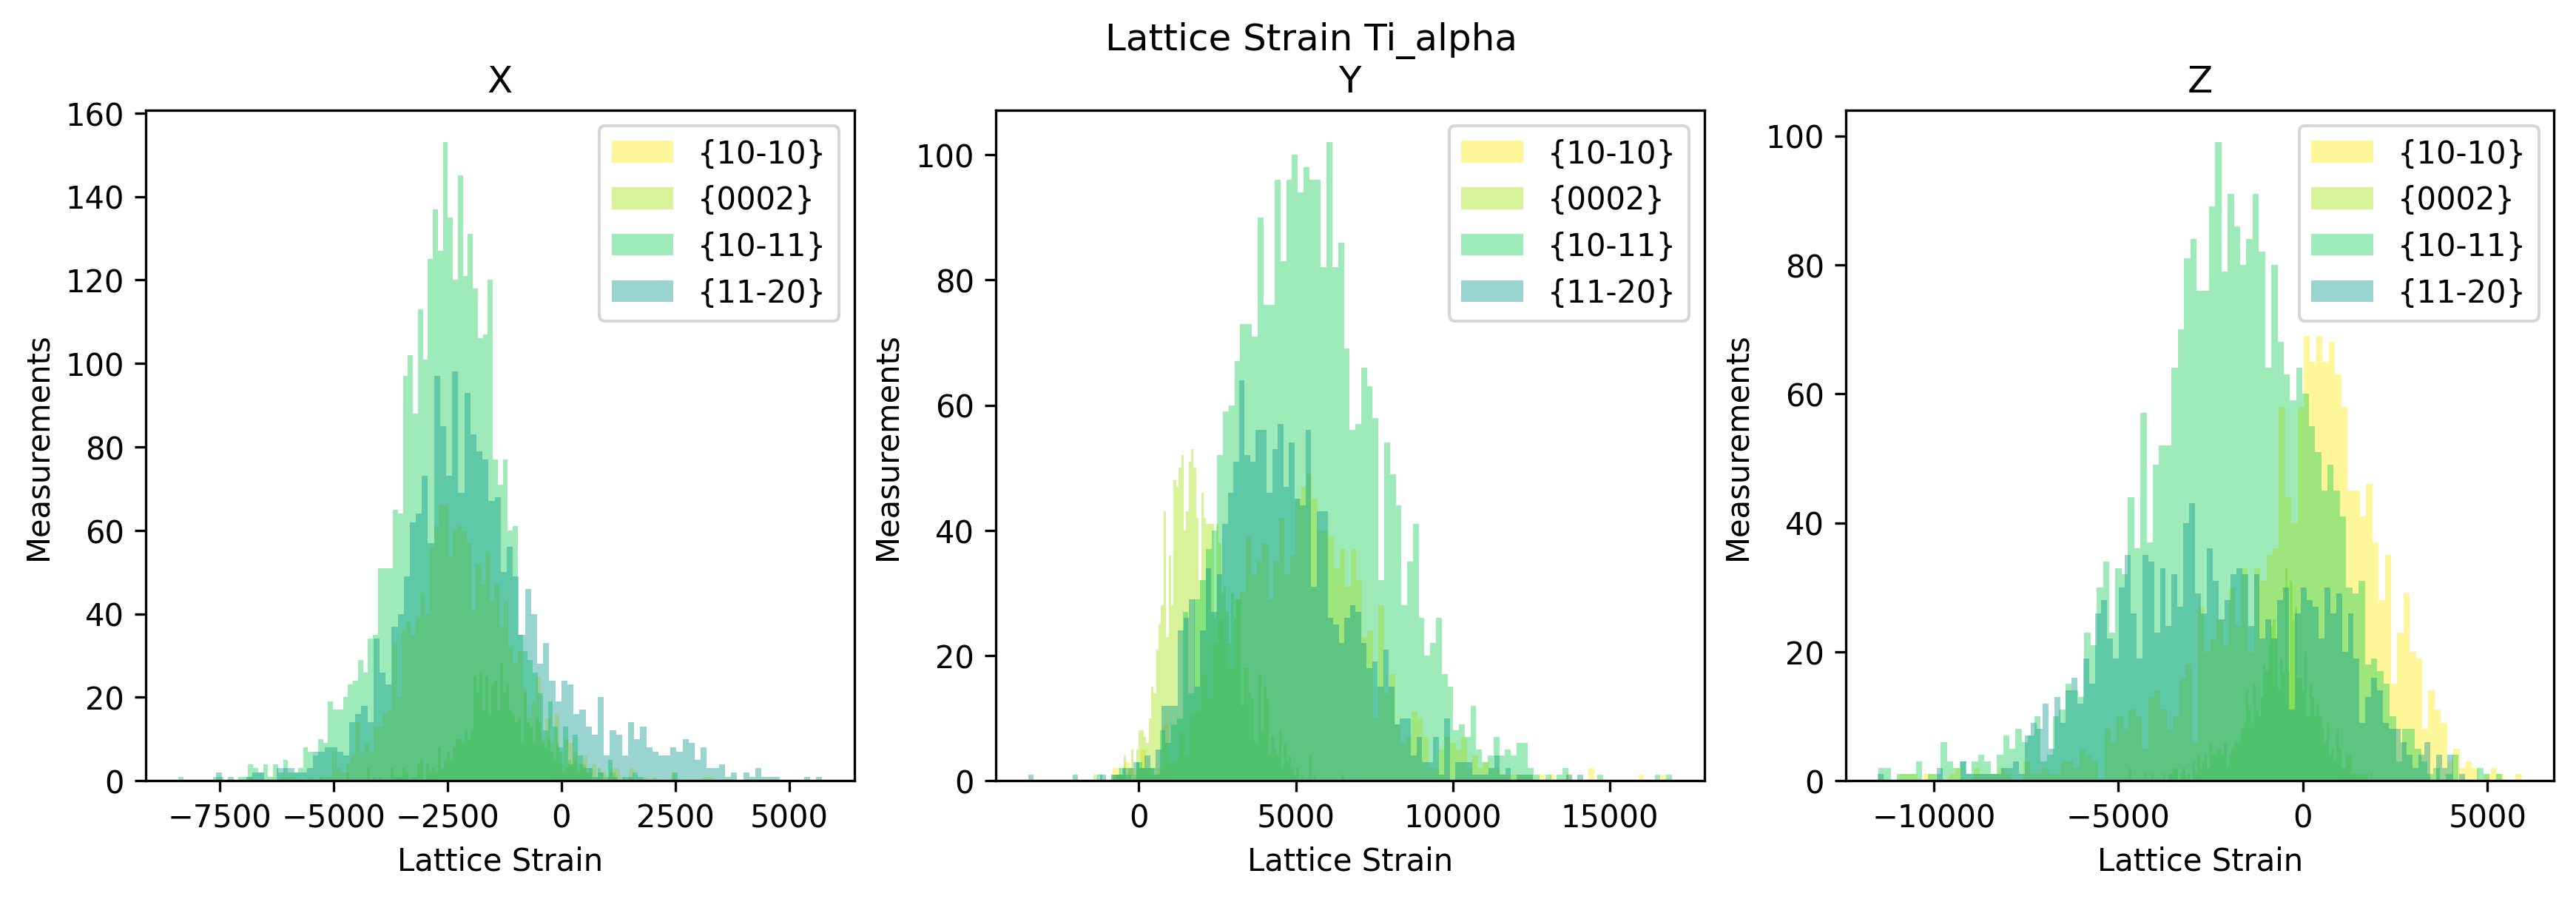

In [6]:
%matplotlib inline

latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

fig1, axs1 = plt.subplots(1,3, figsize=(14, 4), dpi=300, facecolor='w') # one row, three coloumns
fig1.suptitle(f"Lattice Strain Ti_alpha")
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_lattice_strain_dist_inc(axs1[i], latticestrain, axis,
                                 phase="Ti_alpha", inc=100, bins=100,
                                 xmin=None, xlim=None,
                                 ymin=None, ylim=None)
plt.savefig(f'{workflow_dir}Ti_alpha_latticestrain_dist.png')
    
# fig2, axs2 = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
# fig2.suptitle(f"Lattice Strain Ti_beta")
# for i, axis in enumerate(["X", "Y", "Z"]):
#     plot_lattice_strain_dist_inc(axs2[i], latticestrain, axis,
#                                  phase="Ti_beta", inc=100, bins=100,
#                                  xmin=None, xlim=None,
#                                  ymin=None, ylim=None)
# plt.savefig(f'{workflow_dir}Ti_beta_latticestrain_dist.png')

## plot hydrostatic stress against true strain

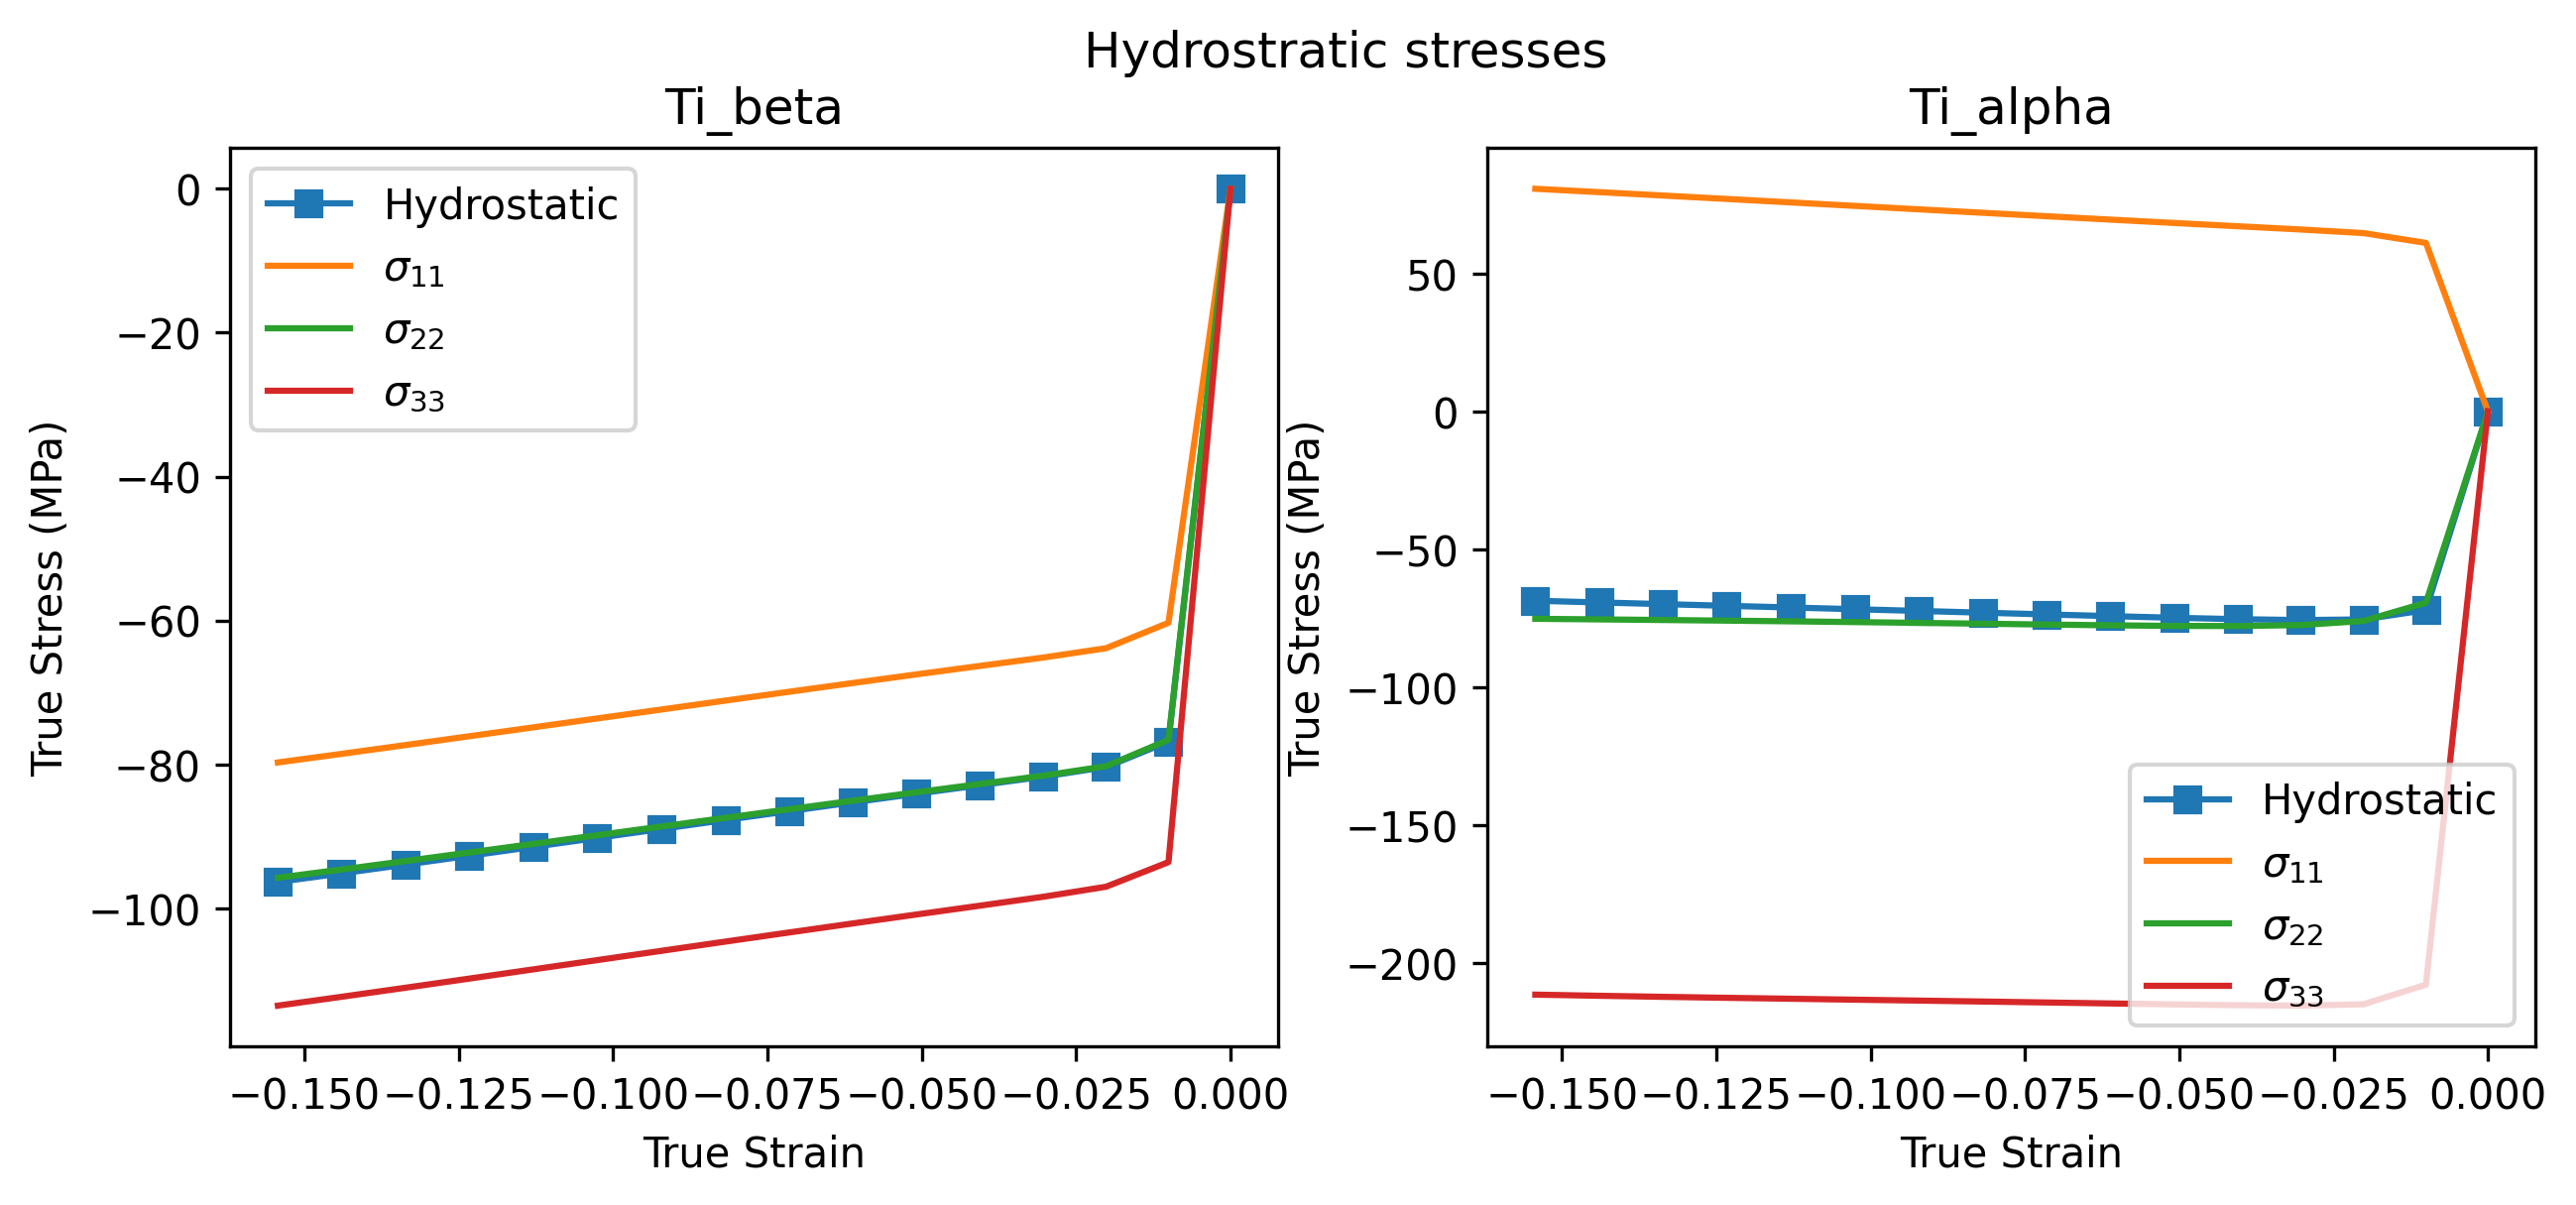

In [4]:

## plot hydrostatic strain with engineering strain

incs = ve_response["volume_data"]['sigma']['meta']['increments']

fig, axs = plt.subplots(1,2, figsize=(10, 4), dpi=300, facecolor='w') # one row, three coloumns
fig.suptitle('Hydrostratic stresses')

hydrostatic_stress = {}
for i, phase in enumerate(sim_ve_load.inputs.phases.keys()):

    # Get hydrostatic stress from tensor components
#     true_strain = ve_response["volume_data"]['epsilon_V^0(F)_vM']['data']
    true_strain = ve_response["volume_data"]['epsilon_V^0(F)']['data'][:, :, 2, 2].mean(axis=1)
    sigma_X = ve_response["phase_data"][f'{phase}_sigma']['data'][:,:,0,0].mean(axis=1)/1e6
    sigma_Y = ve_response["phase_data"][f'{phase}_sigma']['data'][:,:,1,1].mean(axis=1)/1e6
    sigma_Z = ve_response["phase_data"][f'{phase}_sigma']['data'][:,:,2,2].mean(axis=1)/1e6
    triaxial_stress = (sigma_X + sigma_Y + sigma_Z)/3
    
    hydrostatic_stress[phase] = {'true_strain' : true_strain,
                                 'sigma_X' : sigma_X,
                                 'sigma_Y' : sigma_Y,
                                 'sigma_Z' : sigma_Z,
                                 'triaxial_stress' : triaxial_stress,
                                }

    axs[i].plot(true_strain, triaxial_stress,
                marker="s", label="Hydrostatic")
    axs[i].plot(true_strain, sigma_X, label="$\sigma_{11}$")
    axs[i].plot(true_strain, sigma_Y, label="$\sigma_{22}$")
    axs[i].plot(true_strain, sigma_Z, label="$\sigma_{33}$")
    axs[i].set_title(f"{phase}")
    axs[i].set_xlabel("True Strain")
    axs[i].set_xlim(None, None)
    axs[i].set_ylabel("True Stress (MPa)")
    axs[i].set_ylim(None, None)
    axs[i].legend()
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
pickle.dump(hydrostatic_stress, open(workflow_dir+'hydrostatic_stress.pkl', 'wb'))
# save figures
plt.savefig(f'{workflow_dir}hydrostatic_stress.png')

---
## Plot Slip activity with strain

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }

      volume_data: # For global stress-strain
        - field_name: sigma
          out_name: sigma
        - field_name: epsilon_V^0(F)
          out_name: epsilon_V^0(F)
      phase_data: # For global stress-strain
        - phase_name: Ti_alpha
          field_name: gamma_sl
          out_name: Ti_alpha_gamma_sl
        - phase_name: Ti_beta
          field_name: gamma_sl
          out_name: Ti_beta_gamma_sl

    base:
      phases:
        Ti_alpha:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
        Ti_beta:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

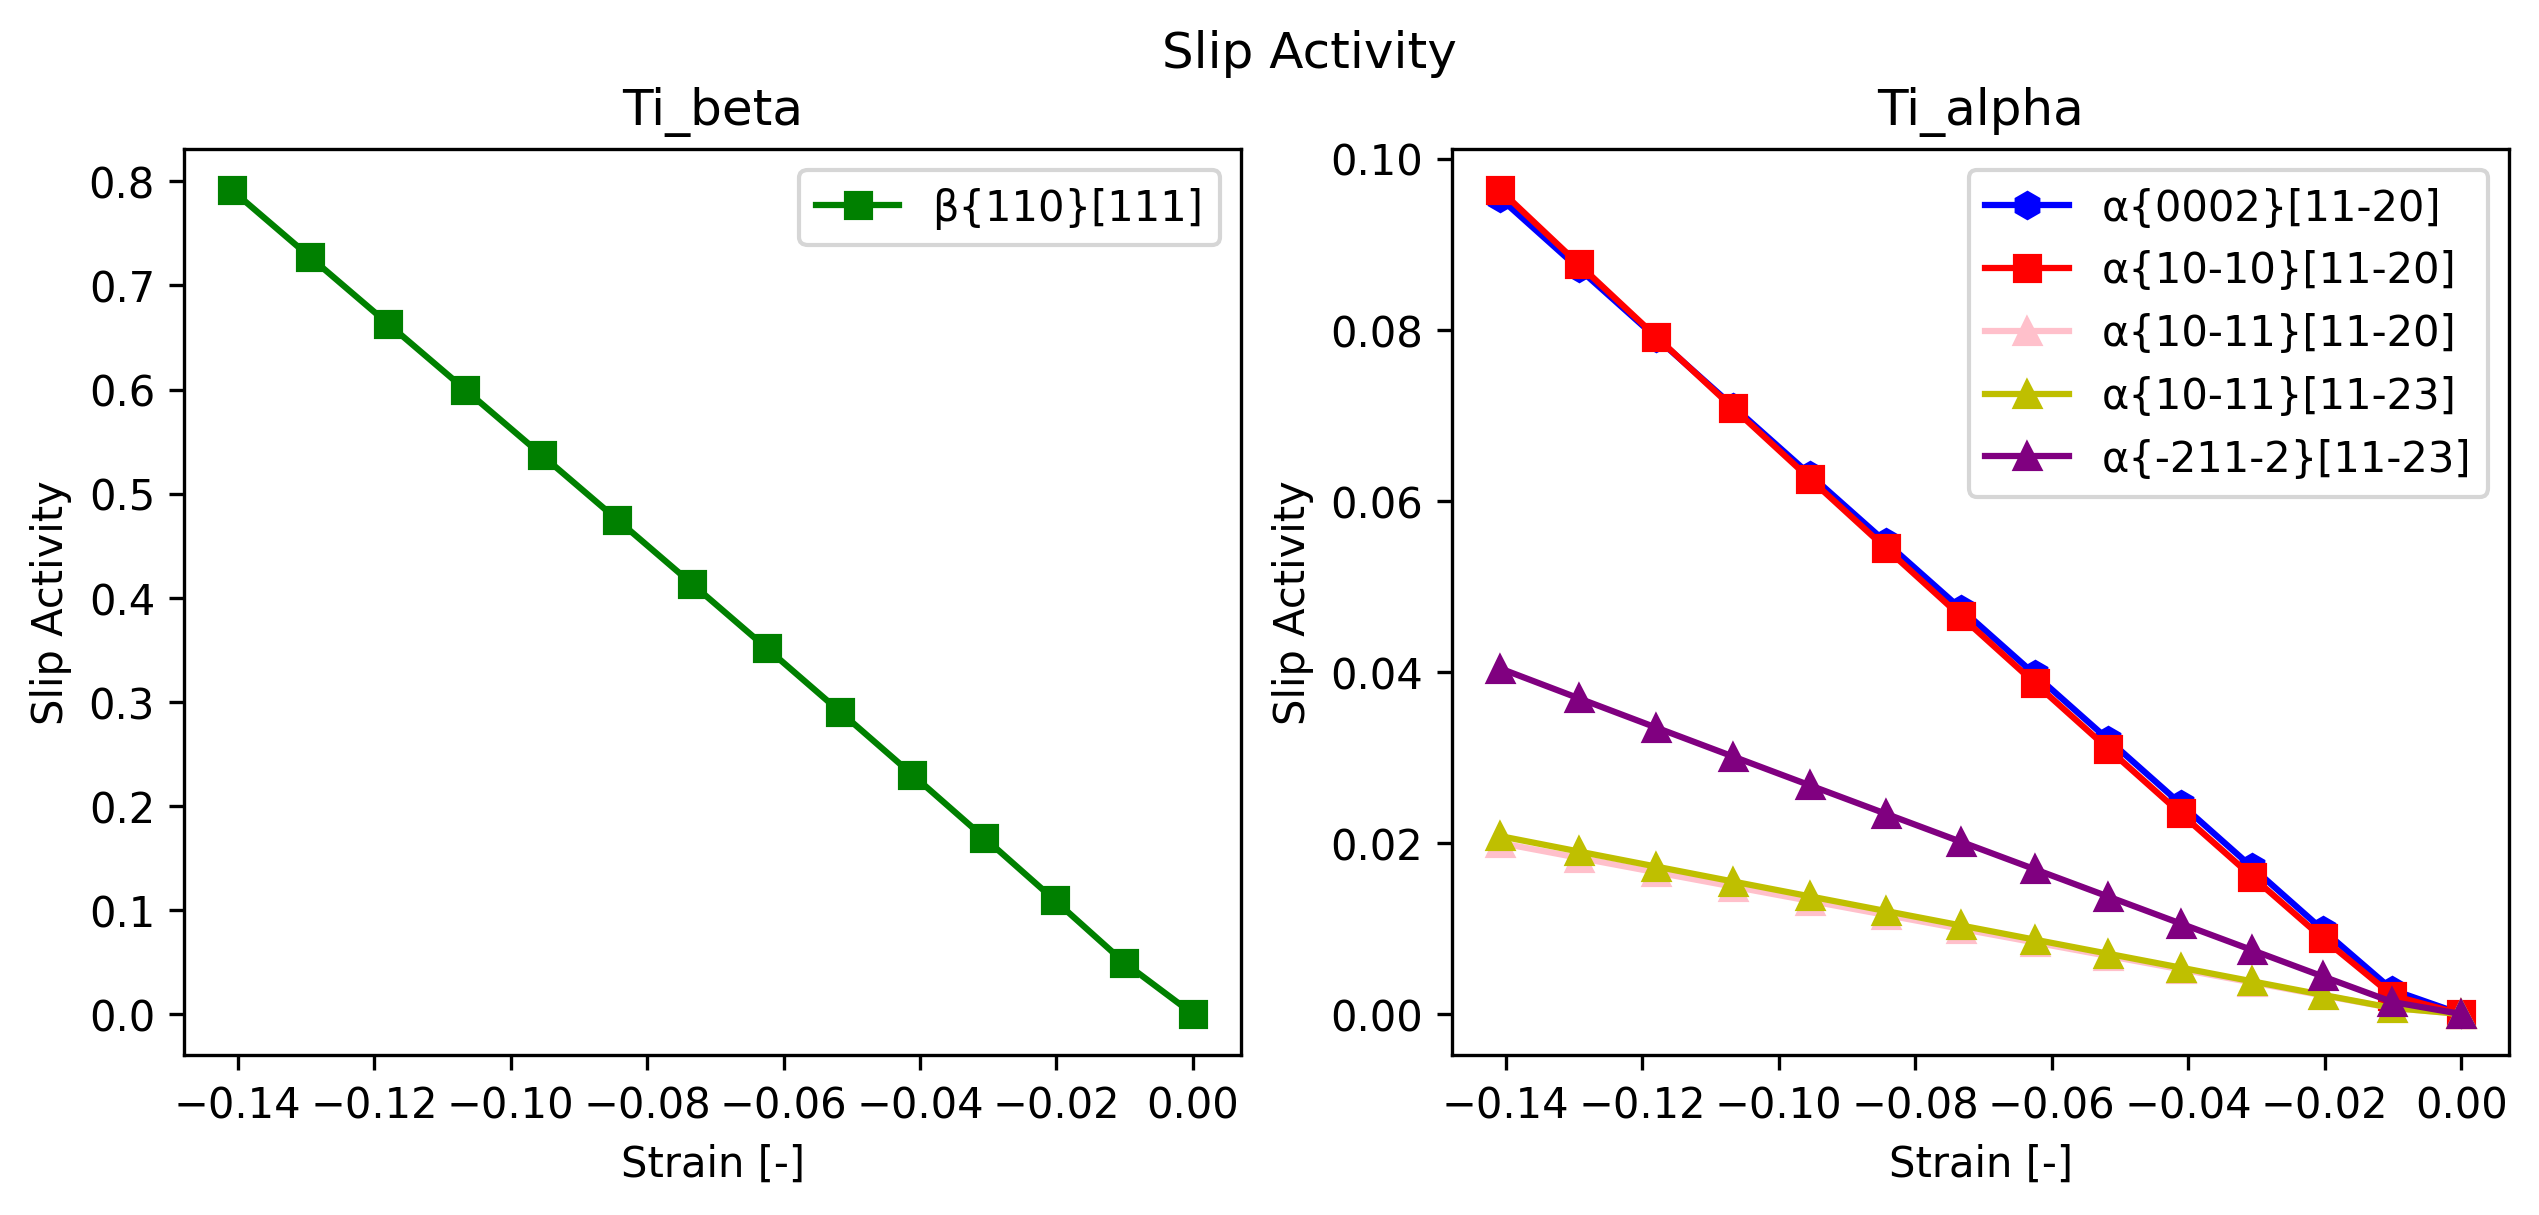

In [9]:

# Plot slip activity
fig, axs = plt.subplots(1,2, figsize=(10, 4), dpi=300, facecolor='w') # one row, three coloumns
fig.suptitle('Slip Activity')

# true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data']
true_strain = ve_response['volume_data']['epsilon_V^0(F)']['data'][:, :, 2, 2].mean(axis=1)
true_stress = ve_response['volume_data']['sigma']['data'][:, 2, 2]/1e6
# true_stress = ve_response['volume_data']['sigma']['data'][:, :, 1, 1].mean(axis=1)/1e6
try:
    alpha_basal_slip = ve_response['phase_data']['Ti_alpha_gamma_sl']['data'][:, :, 0:3].mean(axis=1).sum(axis=1)
    alpha_prism_slip = ve_response['phase_data']['Ti_alpha_gamma_sl']['data'][:, :, 3:6].mean(axis=1).sum(axis=1)
    alpha_pyram_a_slip = ve_response['phase_data']['Ti_alpha_gamma_sl']['data'][:, :, 6:9].mean(axis=1).sum(axis=1)
    alpha_pyram1_ca_slip = ve_response['phase_data']['Ti_alpha_gamma_sl']['data'][:, :, 9:12].mean(axis=1).sum(axis=1)
    alpha_pyram2_ca_slip = ve_response['phase_data']['Ti_alpha_gamma_sl']['data'][:, :, 12:18].mean(axis=1).sum(axis=1)
except:
    print(f"No phase 'Ti_alpha' in workflow. Continuing...")
    alpha_basal_slip = []
    alpha_prism_slip = []
    alpha_pyram_a_slip = []
    alpha_pyram1_ca_slip = []
    alpha_pyram2_ca_slip = []
try:
    beta_slip = ve_response['phase_data']['Ti_beta_gamma_sl']['data'][:, :].mean(axis=1).sum(axis=1)
except:
    print(f"No phase 'Ti_beta' in workflow. Continuing...")
    beta_slip = []

slip_activity = {'true_strain' : true_strain,
                 'true_stress' : true_stress,
                 'alpha_basal_slip' : alpha_basal_slip,
                 'alpha_prism_slip' : alpha_prism_slip,
                 'alpha_pyram_a_slip' : alpha_pyram_a_slip,
                 'alpha_pyram1_ca_slip' : alpha_pyram1_ca_slip,
                 'alpha_pyram2_ca_slip' : alpha_pyram2_ca_slip,
                 'beta_slip' : beta_slip,
                }

for i, phase in enumerate(sim_ve_load.inputs.phases.keys()):
    # Get data from .hdf5
#     axs[i].plot(true_strain, true_stress, label="true_stress", color='k')
    if phase == "Ti_alpha":
        axs[i].plot(true_strain, alpha_basal_slip, label="α{0002}[11-20]", color='b', marker='h')
        axs[i].plot(true_strain, alpha_prism_slip, label="α{10-10}[11-20]", color='r', marker='s')
        axs[i].plot(true_strain, alpha_pyram_a_slip, label="α{10-11}[11-20]", color='pink', marker='^')
        axs[i].plot(true_strain, alpha_pyram1_ca_slip, label="α{10-11}[11-23]", color='y', marker='^')
        axs[i].plot(true_strain, alpha_pyram2_ca_slip, label="α{-211-2}[11-23]", color='purple', marker='^')
    else:
        pass
    if phase == "Ti_beta":
        axs[i].plot(true_strain, beta_slip, label="β{110}[111]", color='g', marker='s')
    else:
        pass
    
    axs[i].set_title(f"{phase}")
    axs[i].set_xlabel("Strain [-]")
    axs[i].set_xlim(None, None)
    axs[i].set_ylabel("Slip Activity")
    axs[i].set_ylim(None, None)
    axs[i].legend()
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
pickle.dump(slip_activity, open(workflow_dir+'slip_activity.pkl', 'wb'))
# save figures
plt.savefig(f'{workflow_dir}slip_activity.png')

---
## Strain distrubution
Distrubution of strains in X, Y and Z axes

In [58]:
from tqdm import tqdm

inc = 16
# ENSURE TO CHANGE STRAIN INC TO DIRECTION OF LOAD
# strain_inc = ve_response["volume_data"][f"epsilon_V^0(F)_vM"]["data"][inc]
strain_inc = ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][:, :, 2, 2].mean(axis=1)[inc]
print(f"Strain in load dir at inc[{inc}]: {strain_inc}")

fig, axs = plt.subplots(1, 2, figsize=(13, 6), dpi=300, facecolor='w')
fontsize=18
fig.suptitle(f'Strain distrubution at inc[{inc}]={strain_inc:.3f} Green Strain', fontsize=fontsize)

for n, subplot in enumerate(["TD", "ND"]):
    axs[n].grid(zorder=0)
    axs[n].axhline(0,color='k',zorder=2) # x = 0
    axs[n].axvline(0,color='k',zorder=2) # y = 0
    axs[n].set_xlim(-2, 2)
    axs[n].set_ylim(-2, 2)
    # annotations
    axs[n].set_title(f"Strain {subplot}-RD plane", size=fontsize)
    axs[n].set_facecolor("white")
    axs[n].set_xlabel(f"Strain $\epsilon_{{{subplot}}}$ [-]", fontsize=fontsize)
    axs[n].set_ylabel(f"Strain $\epsilon_{{RD}}$ [-]", fontsize=fontsize)
    
    alpha_present = False
    beta_present = False
    
    phase_strain_dist = {}
    for phase in ["Ti_beta"]:
        phase_strain_dist[f'{phase}'] = {
#            # if using volume data (single-phase)
#             f'strainRD':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 0, 0],
#             f'strainTD':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 1, 1],
#             f'strainND':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 2, 2],
#             f'av_strainRD':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 0, 0].mean(axis=0),
#             f'av_strainTD':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 1, 1].mean(axis=0),
#             f'av_strainND':ve_response["volume_data"][f"epsilon_V^0(F)"]["data"][inc, :, 2, 2].mean(axis=0),
            
#            # if using phase data (dual-phase)
            f'strainRD':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 0, 0],
            f'strainTD':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 1, 1],
            f'strainND':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 2, 2],
            f'av_strainRD':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 0, 0].mean(axis=0),
            f'av_strainTD':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 1, 1].mean(axis=0),
            f'av_strainND':ve_response["phase_data"][f"{phase}_epsilon_V^0(F)"]["data"][inc, :, 2, 2].mean(axis=0),
        }
        strain_figx_dist = phase_strain_dist[f'{phase}'][f'strain{subplot}']
        strain_X_dist = phase_strain_dist[f'{phase}']['strainRD']
        strain_figx_av = phase_strain_dist[f'{phase}'][f'av_strain{subplot}']
        strain_X_av = phase_strain_dist[f'{phase}']['av_strainRD']

        # colouring quats by IPF colour
        quats = np.array([])
        if subplot=="TD":
            IPF_direction = np.array([0,0,1]) # Z (ND)
        elif subplot=="ND":
            IPF_direction = np.array([0,1,0]) # Y (TD)
            
        # --- XorZ against Y distrubution --- #
        if phase=="Ti_alpha":
            alpha_present = True
            alpha_strainx_av = strain_figx_av
            alpha_strainX_av = strain_X_av
            for q in tqdm(ve_response["phase_data"][f"{phase}_orientations"]['data']['quaternions'][inc,:,:]):
                quats = np.append(quats, Quat(q))
            
            symGroup = "hexagonal" # "cubic"
            IPF_colours = Quat.calcIPFcolours(quats, IPF_direction, symGroup).T
            
            axs[n].scatter(strain_figx_dist, strain_X_dist, # RD up, TD/ZND RHS
                           color=IPF_colours, marker='h', zorder=4,
                           s=150, alpha=0.5, linewidth=0,
                           label=f"{phase}")
            # average
            axs[n].scatter(strain_figx_av, strain_X_av,
                           marker='h', s=200, color="k", zorder=5,
                           label=f"{phase}_av")
            # average lines
#             axs[n].plot([-10, strain_figx_av], [strain_Y_av, strain_Y_av],
#                            linestyle="dashed", marker="None", color="k", zorder=5)
#             axs[n].plot([strain_figx_av, strain_figx_av], [-10, strain_Y_av],
#                            linestyle="dashed", marker="None", color="k", zorder=5)
#             print(f"{phase} av {subplot} strain:({strain_figx_av})")
            
        elif phase=="Ti_beta":
            beta_present = True
            beta_strainx_av = strain_figx_av
            beta_strainX_av = strain_X_av
            for q in tqdm(ve_response["phase_data"][f"{phase}_orientations"]['data']['quaternions'][inc,:,:]):
                quats = np.append(quats, Quat(q))
            
            symGroup = "cubic" # "cubic"
            IPF_colours = Quat.calcIPFcolours(quats, IPF_direction, symGroup).T
            axs[n].scatter(strain_figx_dist, strain_X_dist,  # X(RD) up, Y(TD)/Z(ND) RHS 
                           color=IPF_colours, marker='h', zorder=4,
                           s=150, alpha=0.5, linewidth=0,
                           label=f"{phase}")
           # average
            axs[n].scatter(strain_figx_av, strain_X_av, # X(RD) up, Y(TD)/Z(ND) RHS
                           marker='s', s=200, color="k", zorder=5,
                           label=f"{phase}_av")
#            # average lines
#             axs[n].plot([-10, strain_figx_av], [strain_Y_av, strain_Y_av],
#                            linestyle="dashed", marker="None", color="k", zorder=5)
#             axs[n].plot([strain_figx_av, strain_figx_av], [-10, strain_Y_av],
#                            linestyle="dashed", marker="None", color="k", zorder=5)
#             print(f"{phase} av {subplot} strain:({strain_figx_av})")
#         else:
#             print(f"No phases {phase} defined.")
            
        axs[n].legend()
        
#     print(f"{phase} av RD strain:({strain_X_av})")

# if alpha_present & beta_present:
#     print(f"av Strain ratio {subplot}:{beta_strainx_av/alpha_strainx_av} X:{beta_strainX_av/alpha_strainX_av}")

plt.show()
# save stress_strain dict as .pkl file to avoid reloading workflow.hdf5 file:
pickle.dump(phase_strain_dist, open(workflow_dir+'phase_strain_dist.pkl', 'wb'))
# save figures
# plt.savefig(f'{workflow_dir}strain_dist.png')

IndexError: index 16 is out of bounds for axis 0 with size 16

---
## Viscocity
(work in progress)

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Viscocity')

phases_ss = {}
for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
    # Get volume and phase stresses
    stress = ve_response["volume_data"]["sigma"]["data"][:, :, i, i].mean(axis=1)[1:]/1e6 # MPa
    alpha_stress = ve_response["phase_data"]["Ti_alpha_sigma"]["data"][:, :, i, i].mean(axis=1)[1:]/1e6 # MPa
    beta_stress = ve_response["phase_data"]["Ti_beta_sigma"]["data"][:, :, i, i].mean(axis=1)[1:]/1e6 # MPa

    # get time at each inc
    t = np.array(ve_response['volume_data']['sigma']['meta']['increments'][1:])/1000
    
    # calculate strain rates from strains/time
    sr = ve_response["volume_data"]["epsilon_V^0(F)"]["data"][:, :, i, i].mean(axis=1)[1:]/t
    alpha_strain = ve_response["phase_data"]["Ti_alpha_epsilon_V^0(F)"]["data"][:, :, i, i].mean(axis=1)[1:]/1e6 # MPa
    alpha_sr = alpha_strain/t
    beta_strain = ve_response["phase_data"]["Ti_beta_epsilon_V^0(F)"]["data"][:, :, i, i].mean(axis=1)[1:]/1e6 # MPa
    beta_sr = beta_strain/t
    
    k = stress/(sr) # need strain rate gradient tensor F?
    k_alpha = alpha_stress/(alpha_sr)
    k_beta = beta_stress/(beta_sr)
    
    axs[i].plot(k_alpha/k_beta, k/k_alpha)
    axs[i].set_title(f"{axis}")
    axs[i].set_xlabel(f"$k_α/k_β$")
#     axs[i].set_xlim(1,7)
    axs[i].set_ylabel(f"$k/k_α$")
#     axs[i].set_ylim(0,1)
    

---
# Works in progress

## Plot plane-masked stress against true strain

In [ ]:

phases = import_diff_params("Ti_alpha", "Ti_beta")

# Using left Cauchy-Green defomation tensor for elastic strain...
stress = ve_response['phase_data']['Ti_alpha_sigma']['data']
stress_incs = ve_response['volume_data']['sigma']['meta']['increments']

# get number of increments...
oris = ve_response['field_data']['O']['data']
ori_incs = ve_response['field_data']['O']['meta']['increments']

stress_diffraction={}
plane_intensity={}
for axis in ["X", "Y", "Z"]: # plot subsequent plots for every axis direction

    for phase_name, phase in phases.items():
        phase_idx, phase_mask = VE_phase_mask(phase_name, ve_response)
    
        # calculate lattice strains and count material points with that lattice strain
        stress_diffraction[axis], plane_intensity[axis] = lattice_strain(stress, stress_incs, oris, ori_incs, phase_idx, phase_mask, phases, axis)
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
with open(workflow_dir+'stress_diffraction.pkl', 'wb') as sd:
    pickle.dump(stress_diffraction, sd)
with open(workflow_dir+'plane_intensity.pkl', 'wb') as pi:
    pickle.dump(plane_intensity, pi)


In [ ]:
%matplotlib inline

true_strain = ve_response['volume_data']['epsilon_V^0(F)']['data'][:,:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]
stress_diffraction = pickle.load(open(workflow_dir+'stress_diffraction.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Diffracted stress against Strain')
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_latticestrain(axs[i], stress_diffraction, true_strain, axis, incs="*", xlim=None, ylim=None)

---
## Template to add your own analysis

In [ ]:

# Template 
fig, axs = plt.subplots(1,2, figsize=(10, 4), dpi=300) # one row, three coloumns
fig.suptitle('title')

data_dict = {}
for i, phase in enumerate(phases):

    # Get data from .hdf5
    axs[i].plot(data_y, data_x, label="")
    axs[i].set_title(f"subtitle")
    axs[i].set_xlabel("xlabel")
    axs[i].set_xlim(None, None)
    axs[i].set_ylabel("ylabel")
    axs[i].set_ylim(None, None)
    axs[i].legend()
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
pickle.dump(data_dict, open(workflow_dir+'data_dict.pkl', 'wb'))
